In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = -1

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"

In [7]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

### Petits tests

In [ ]:
gain_MILP = []
U = np.linspace(-8400000,8400000,1)
for x in U:
    m = retrieve_problem(1,1)
    m = modify_objective(m,x)
    m = milp_version(m)
    m.controls.xslp_log = -1
    m.solve()
    # m.lpoptimize()
    gain_MILP.append(m.getObjVal())

In [ ]:
gain_LR = []
U = np.linspace(-8400000,8400000,10)
for x in U:
    m = retrieve_problem(1,1)
    m = modify_objective(m,x)
    m.controls.xslp_log = -1
    m.solve()
    gain_LR.append(m.getObjVal())

In [ ]:
plt.plot(U,gain_LR)
plt.plot(U,gain_MILP)

### Fonctions de gain

In [8]:
# U = np.array([-128016,0,480606,961212,1441818,1922424,2403030,2883636,3364242,3844848])
S = 52
NTrain = 1
H = 168

In [9]:
n_controls = 9
reward = read_r(study_path+"/user/reward_9sim_fast_fi00.RData")
reward = reward['reward']
U = reward['control'].values.reshape((S,n_controls))

#### Fast 2 RL

In [45]:
reward = read_r(study_path+"/user/reward_9sim_fast_fi00.RData")
reward = reward['reward']
reward_fast_2_RL = np.zeros((n_controls, S, NTrain))
for s in range(S):
    for k in range(NTrain):
            for u in range(n_controls): 
                reward_fast_2_RL[u,s,k] = reward.loc[(reward["mcYear"]==k+1)&(reward["timeId"]==s+1)&(reward["control"]==U[s,u])].iloc[0,2]

#### Accurate 2 RL

In [60]:
reward = read_r(study_path+"/user/reward_9sim_accurate_fi00.RData")
reward = reward['reward']
reward_accurate_2_RL = np.zeros((n_controls, S, NTrain))
for s in range(S):
    for k in range(NTrain):
            for u in range(n_controls): 
                reward_accurate_2_RL[u,s,k] = reward.loc[(reward["mcYear"]==k+1)&(reward["timeId"]==s+1)&(reward["control"]==U[s,u])].iloc[0,2]

#### Fast 1 RL

In [26]:
output_path = study_path+"/user/fast_fi00"

In [27]:
reward_fast_1_RL = np.zeros((n_controls, S, NTrain))

for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        m = retrieve_problem(k+1,s+1,output_path)
        m.controls.xslp_log = -1
        for u in range(n_controls): 
            m = modify_objective(m,U[s,u])
            m.solve()
            reward_fast_1_RL[u,s,k] =  -m.getObjVal() 

#### Accurate 1 RL

In [67]:
output_path = study_path+"/user/accurate_fi00"

In [68]:
reward_accurate_1_RL = np.zeros((n_controls, S, NTrain))

for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        m = retrieve_problem(k+1,s+1,output_path)
        m.controls.xslp_log = -1
        for u in range(n_controls): 
            m = modify_objective(m,U[s,u])
            m.solve()
            reward_accurate_1_RL[u,s,k] =  -m.getObjVal() 

In [29]:
# reward = np.zeros((n_controls, S, NTrain))
# for u in range(n_controls):
#     reward[u, :, :] = reward_accurate_1_RL[(U>=0).argmax(), :, :] - reward_accurate_1_RL[u, :, :]
# reward_accurate_1_RL = reward

#### Accurate 1 MILP

In [79]:
output_path = study_path+"/user/accurate_fi00"

In [80]:
reward_accurate_1_MILP = np.zeros((n_controls, S, NTrain)) # 150 minutes environ pour 1 scénario et 9 contrôles

for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        m = retrieve_problem(k+1,s+1,output_path)
        m = milp_version(m)
        m.controls.xslp_log = -1
        for u in range(1):#n_controls): 
            m = modify_objective(m,U[s,u])
            m.solve()
            reward_accurate_1_MILP[u,s,k] =  -m.getObjVal() 

In [34]:
# reward = np.zeros((n_controls, S, NTrain))
# for u in range(n_controls):
#     reward[u, :, :] = reward_accurate_1_MILP[(U>=0).argmax(), :, :] - reward_accurate_1_MILP[u, :, :]
# reward_accurate_1_MILP = reward

#### Save

In [70]:
# np.savez(study_path+"/user/rewards_python_fi00", reward_accurate_1_MILP=reward_accurate_1_MILP, reward_accurate_1_RL=reward_accurate_1_RL, reward_accurate_2_RL=reward_accurate_2_RL,reward_fast_1_RL=reward_fast_1_RL,reward_fast_2_RL=reward_fast_2_RL)

In [50]:
npzfile = np.load(study_path+"/user/rewards_python_fi00.npz")

In [51]:
reward_fast_1_RL = npzfile["reward_fast_1_RL"]
# reward_fast_2_RL = npzfile["reward_fast_2_RL"]
reward_accurate_1_RL = npzfile["reward_accurate_1_RL"]
# reward_accurate_2_RL = npzfile["reward_accurate_2_RL"]
reward_accurate_1_MILP = npzfile["reward_accurate_1_MILP"]

#### Plot

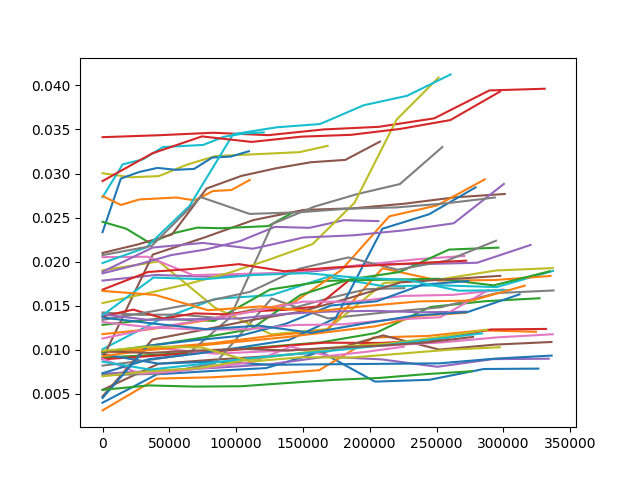

In [61]:
plt.figure()
for s in range(S):
    plt.plot(U[s],(reward_fast_2_RL[:,s,0]-reward_fast_1_RL[:,s,0])/reward_fast_1_RL[:,s,0],label=f"{s}")
# plt.legend()

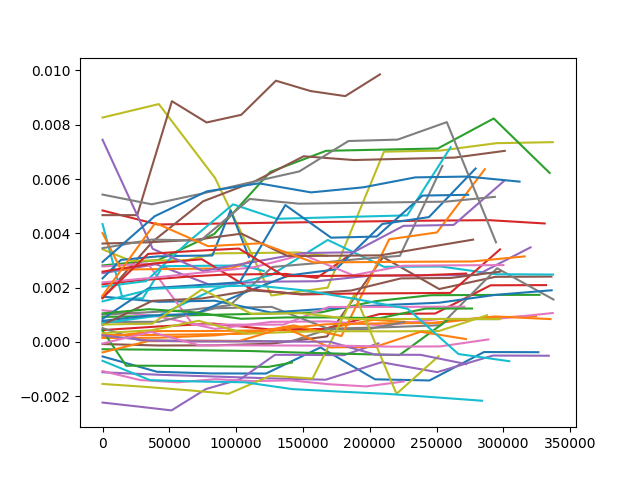

In [67]:
plt.figure()
for s in range(S):
    plt.plot(U[s],(reward_accurate_2_RL[:,s,0]-reward_accurate_1_RL[:,s,0])/reward_accurate_1_RL[:,s,0],label=f"{s}")

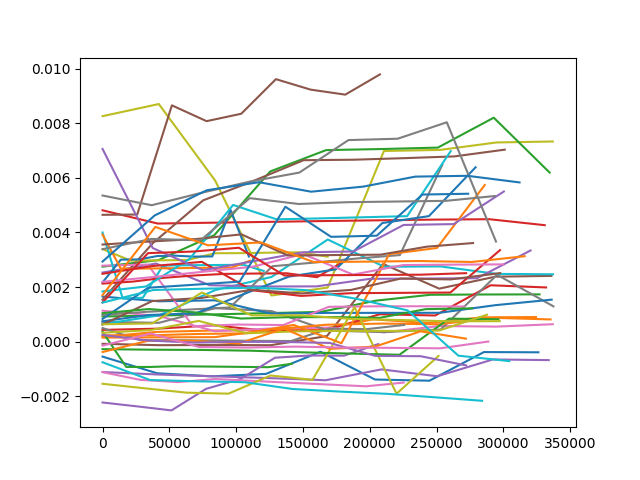

In [68]:
plt.figure()
for s in range(S):
    plt.plot(U[s],(reward_accurate_2_RL[:,s,0]-reward_accurate_1_MILP[:,s,0])/reward_accurate_1_MILP[:,s,0],label=f"{s}")

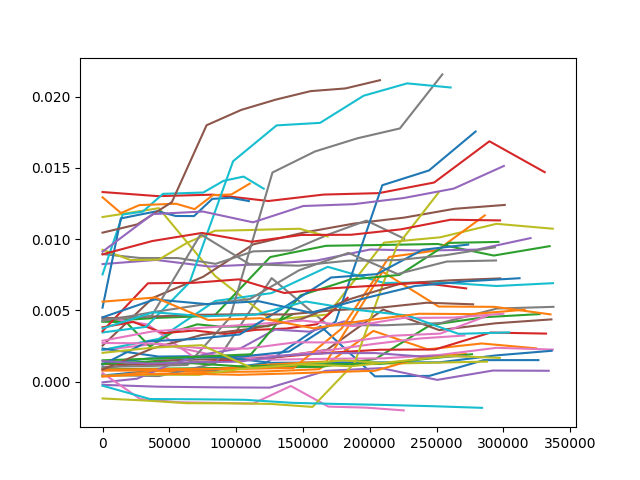

In [69]:
plt.figure()
for s in range(S):
    plt.plot(U[s],(reward_fast_2_RL[:,s,0]-reward_accurate_1_MILP[:,s,0])/reward_accurate_1_MILP[:,s,0],label=f"{s}")

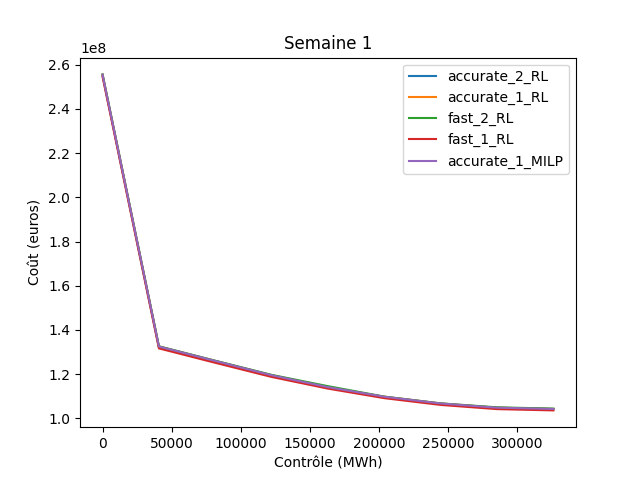

In [117]:
s =0
plt.figure()
plt.title(f"Semaine {s+1}")
plt.xlabel("Contrôle (MWh)")
plt.ylabel("Coût (euros)")
plt.plot(U[s],-reward_accurate_2_RL[:,s,0],label="accurate_2_RL")
plt.plot(U[s],-reward_accurate_1_RL[:,s,0],label="accurate_1_RL")
plt.plot(U[s],-reward_fast_2_RL[:,s,0],label="fast_2_RL")
plt.plot(U[s],-reward_fast_1_RL[:,s,0],label="fast_1_RL")
plt.plot(U[s],-reward_accurate_1_MILP[:,s,0],label="accurate_1_MILP")
plt.legend()

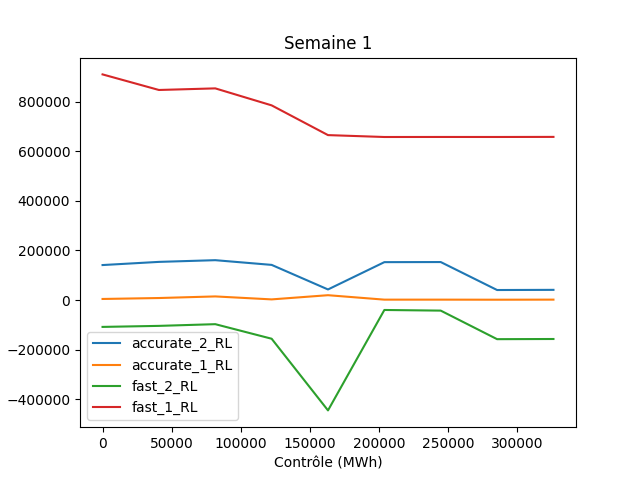

In [118]:
plt.figure()
plt.title(f"Semaine {s+1}")
plt.xlabel("Contrôle (MWh)")
plt.ylabel("Gain (euros)")
plt.plot(U[s],reward_accurate_2_RL[:,s,0]-reward_accurate_1_MILP[:,s,0],label="accurate_2_RL")
plt.plot(U[s],reward_accurate_1_RL[:,s,0]-reward_accurate_1_MILP[:,s,0],label="accurate_1_RL")
plt.plot(U[s],reward_fast_2_RL[:,s,0]-reward_accurate_1_MILP[:,s,0],label="fast_2_RL")
plt.plot(U[s],reward_fast_1_RL[:,s,0]-reward_accurate_1_MILP[:,s,0],label="fast_1_RL")
plt.legend()

#### Démarrages à chaud fast 1 RL

In [128]:
max_turb = U[:,-1]

In [129]:
max_turb

array([326256., 324408., 327096., 331968., 333984., 336000., 337008.,
       337512., 337008., 337176., 336168., 335328., 334656., 330960.,
       320376., 301056., 270816., 225792., 168504., 120624., 109536.,
       110208., 141792., 183456., 206472., 207648., 225456., 254352.,
       251496., 260568., 279216., 286104., 296352., 297528., 300384.,
       297696., 300048., 294504., 287784., 284088., 273672., 271992.,
       276528., 272160., 272160., 277368., 288792., 293664., 297360.,
       304416., 312144., 316008.])

In [130]:
n_controls = 50
U = np.array([np.linspace(0,max_turb[i],num=n_controls) for i in range(52)])

In [343]:
output_path = study_path+"/user/fast_fi00"

##### Toute la boucle

In [58]:
reward_fast_1_RL = np.zeros((n_controls, S, NTrain))

start = time()
for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        m = retrieve_problem(k+1,s+1,output_path)
        m.controls.xslp_log = -1
        cst = m.getConstraint()
        binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
        for u in range(n_controls): 
            m.chgrhs(binding_id,[U[s,u]])
            m.lpoptimize()
            reward_fast_1_RL[u,s,k] =  m.getObjVal() 
end = time()
print(end-start) # pour 9 : 136s, pour 50 : 512s

512.2045161724091


In [59]:
reward_fast_1_RL = np.zeros((n_controls, S, NTrain))

start = time()
for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        rstatus = []
        cstatus = []
        m = retrieve_problem(k+1,s+1,output_path)
        m.controls.xslp_log = -1
        cst = m.getConstraint()
        binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
        for u in range(n_controls): 
            m.chgrhs(binding_id,[U[s,u]])
            if len(rstatus)>0:
                m.loadbasis(rstatus, cstatus)
            m.lpoptimize()
            m.getbasis(rstatus, cstatus)
            reward_fast_1_RL[u,s,k] =  m.getObjVal() 
end = time()
print(end-start) # pour 9 : 151s, pour 50 : 628s

628.4766433238983


In [25]:
reward_fast_1_RL = np.zeros((n_controls, S, NTrain))

start = time()
rstatus = []
cstatus = []
for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        m = retrieve_problem(k+1,s+1,output_path)
        if len(rstatus)>0:
            m.loadbasis(rstatus, cstatus)
        cst = m.getConstraint()
        binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
        for u in range(n_controls): 
            m.chgrhs(binding_id,[U[s,u]])
            m.lpoptimize()
            reward_fast_1_RL[u,s,k] =  m.getObjVal() 
        m.getbasis(rstatus, cstatus)
end = time()
print(end-start) # pour 50 : 684 s

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
684.0110442638397


In [9]:
reward_fast_1_RL = np.zeros((n_controls, S, NTrain))

start = time()
for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        for u in range(n_controls): 
            m = retrieve_problem(k+1,s+1,output_path)
            cst = m.getConstraint()
            binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
            m.chgrhs(binding_id,[U[s,u]])
            m.lpoptimize()
            reward_fast_1_RL[u,s,k] =  m.getObjVal() 
end = time()
print(end-start) # pour 9 controles : 614s

0







1








2








3








4








5








6








7








8








9








10








11








12








13








14








15








16








17








18








19








20








21








22








23








24








25








26








27








28








29








30








31








32








33








34








35








36








37








38








39








40








41








42








43








44








45








46








47








48








49








50








51








614.195033788681


In [10]:
reward_fast_1_RL = np.zeros((n_controls, S, NTrain))

start = time()
rstatus = []
cstatus = []
for s in range(S):
    print(s, end="\r")
    for k in range(NTrain):
        for u in range(n_controls): 
            m = retrieve_problem(k+1,s+1,output_path)
            m.controls.xslp_log = -1
            if len(rstatus)>0:
                m.loadbasis(rstatus, cstatus)
            cst = m.getConstraint()
            binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
            m.chgrhs(binding_id,[U[s,u]])
            m.lpoptimize()
            reward_fast_1_RL[u,s,k] =  m.getObjVal() 
            m.getbasis(rstatus, cstatus)
end = time()
print(end-start) # pour 9 controles : 548s

0
548.6942653656006


##### Une itération

In [12]:
rstatus = []
cstatus = []

In [13]:
u = 0

In [29]:
m = retrieve_problem(1,1,output_path)
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()
m.getbasis(rstatus, cstatus)

Reading Problem Pb Solve
Problem Statistics
       21291 (      1 spare) rows
       94080 (      0 spare) structural columns
      201765 (  87192 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members

FICO Xpress v8.14.8, Hyper, solve started 15:39:54, Jan 11, 2024
Heap usage: 27MB (peak 27MB, 8695KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9279 rows        44736 cols        95211 elements
Presolve finished in 0 seconds
Heap usage: 34MB (peak 68MB, 8695KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [10.00e-06,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  

In [17]:
m.loadbasis(rstatus, cstatus)

In [18]:
m.solve()

FICO Xpress v8.14.8, Hyper, solve started 14:56:03, Jan 11, 2024
Heap usage: 33MB (peak 68MB, 8673KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9279 rows        44736 cols        95211 elements
Presolve finished in 0 seconds
Heap usage: 41MB (peak 68MB, 8673KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [ 1.00e-05,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  1.00e+04]
Autoscaling applied standard scaling

Starting parallel dual simplex, using up to 8 threads
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       254578873.4      D      0     0        .000000     0
Uncrunching m

In [19]:
u = 1
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

FICO Xpress v8.14.8, Hyper, solve started 14:57:13, Jan 11, 2024
Heap usage: 33MB (peak 68MB, 8673KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9624 rows        45392 cols        96743 elements
Presolve finished in 0 seconds
Heap usage: 41MB (peak 68MB, 8673KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [ 1.00e-05,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  1.00e+04]
Autoscaling applied standard scaling

Starting parallel dual simplex, using up to 8 threads
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       187996090.3      D      4     0        .000000     0
    30       

In [20]:
u = 1
m = retrieve_problem(1,1,output_path)
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

Reading Problem Pb Solve
Problem Statistics
       21291 (      1 spare) rows
       94080 (      0 spare) structural columns
      201765 (  87192 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members

FICO Xpress v8.14.8, Hyper, solve started 14:58:58, Jan 11, 2024
Heap usage: 27MB (peak 27MB, 8675KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9624 rows        45392 cols        96743 elements
Presolve finished in 0 seconds
Heap usage: 35MB (peak 68MB, 8675KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [10.00e-06,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  

In [21]:
u = 0
m = retrieve_problem(1,1,output_path)
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

Reading Problem Pb Solve
Problem Statistics
       21291 (      1 spare) rows
       94080 (      0 spare) structural columns
      201765 (  87192 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members

FICO Xpress v8.14.8, Hyper, solve started 15:01:08, Jan 11, 2024
Heap usage: 27MB (peak 27MB, 8678KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9279 rows        44736 cols        95211 elements
Presolve finished in 0 seconds
Heap usage: 34MB (peak 68MB, 8678KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [10.00e-06,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  

In [22]:
u = 1
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

FICO Xpress v8.14.8, Hyper, solve started 15:01:21, Jan 11, 2024
Heap usage: 33MB (peak 68MB, 8678KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9624 rows        45392 cols        96743 elements
Presolve finished in 0 seconds
Heap usage: 41MB (peak 68MB, 8678KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [ 1.00e-05,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  1.00e+04]
Autoscaling applied standard scaling

Starting parallel dual simplex, using up to 8 threads
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       187996090.3      D      2     0        .000000     0
    29       

In [27]:
u = 0
m = retrieve_problem(1,1,output_path)
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

Reading Problem Pb Solve
Problem Statistics
       21291 (      1 spare) rows
       94080 (      0 spare) structural columns
      201765 (  87192 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members

FICO Xpress v8.14.8, Hyper, solve started 15:37:34, Jan 11, 2024
Heap usage: 27MB (peak 27MB, 8692KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9279 rows        44736 cols        95211 elements
Presolve finished in 0 seconds
Heap usage: 34MB (peak 68MB, 8692KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [10.00e-06,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  

In [28]:
m.lpoptimize()

FICO Xpress v8.14.8, Hyper, solve started 15:37:57, Jan 11, 2024
Heap usage: 33MB (peak 68MB, 8692KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9279 rows        44736 cols        95211 elements
Presolve finished in 1 seconds
Heap usage: 41MB (peak 68MB, 8692KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [ 1.00e-05,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  1.00e+04]
Autoscaling applied standard scaling

Starting parallel dual simplex, using up to 8 threads
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       254578873.4      D      0     0        .000000     1
Uncrunching m

In [30]:
u = 0
m = retrieve_problem(1,1,output_path)
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
m.loadbasis(rstatus, cstatus)
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

Reading Problem Pb Solve
Problem Statistics
       21291 (      1 spare) rows
       94080 (      0 spare) structural columns
      201765 (  87192 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members

FICO Xpress v8.14.8, Hyper, solve started 15:41:06, Jan 11, 2024
Heap usage: 27MB (peak 27MB, 8697KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9279 rows        44736 cols        95211 elements
Presolve finished in 0 seconds
Heap usage: 34MB (peak 68MB, 8697KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [ 1.00e-05,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  

In [31]:
u = 1
m = retrieve_problem(1,1,output_path)
cst = m.getConstraint()
binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
m.loadbasis(rstatus, cstatus)
m.chgrhs(binding_id,[U[0,u]])
m.lpoptimize()

Reading Problem Pb Solve
Problem Statistics
       21291 (      1 spare) rows
       94080 (      0 spare) structural columns
      201765 (  87192 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members

FICO Xpress v8.14.8, Hyper, solve started 15:41:56, Jan 11, 2024
Heap usage: 27MB (peak 27MB, 8699KB system)
Minimizing LP Pb Solve using up to 8 threads and up to 31GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
     21291 rows        94080 cols       201765 elements
Presolved problem has:
      9624 rows        45392 cols        96743 elements
Presolve finished in 0 seconds
Heap usage: 35MB (peak 68MB, 8699KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 1.01e-02,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  5.78e+07] / [ 1.00e-05,  2.97e+06]
  Objective      [min,max] : [ 5.00e-04,  1.00e+04] / [ 1.96e-05,  

##### Détail sur toute la boucle

In [344]:
def function_to_time():
    reward_fast_1_RL = np.zeros((n_controls, S, NTrain))
    simplex_itr = np.zeros((n_controls, S, NTrain))
    for s in range(S):
        print(s, end="\r")
        for k in range(NTrain):
            m = xp.problem()
            m.read(output_path+f"/problem-{k+1}-{s+1}--optim-nb-{1}.mps")
            m.controls.xslp_log = -1
            cst = m.getConstraint()
            binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
            for u in range(n_controls): 
                m.chgrhs(binding_id,[U[s,u]])
                m.lpoptimize()
                reward_fast_1_RL[u,s,k] =  m.getObjVal() 
                simplex_itr[u,s,k] = m.attributes.SIMPLEXITER
    return reward_fast_1_RL, simplex_itr

In [21]:
%lprun -f function_to_time res=function_to_time()

Timer unit: 1e-07 s

Total time: 568.24 s

Could not find file C:\Users\gerbauxjul\AppData\Local\Temp\ipykernel_10084\434246469.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2         1        132.0    132.0      0.0  
     3                                           
     4        53        586.0     11.1      0.0  
     5        52     144376.0   2776.5      0.0  
     6       104       2149.0     20.7      0.0  
     7        52   15696063.0 301847.4      0.3  
     8        52  361011227.0    7e+06      6.4  
     9        52       4371.0     84.1      0.0  
    10        52    1645364.0  31641.6      0.0  
    11        52    6395926.0 122998.6      0.1  
    12      2652      38136.0     14.4      0.0  
    13      2600     416005.0    160.0      0.0  
    14      2

In [345]:
reward_fast_1_RL, simplex_itr=function_to_time()

C:\Users\gerbauxjul\AppData\Local\Temp\ipykernel_19808\4257885213.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


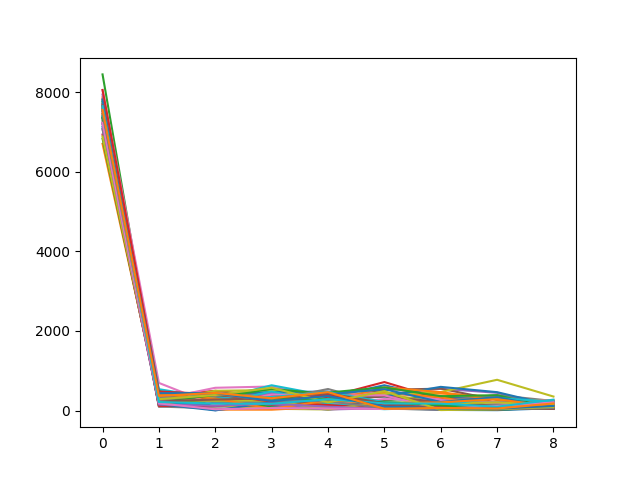

In [346]:
plt.figure()
for s in range(S):
    plt.plot(simplex_itr[:,s,k])

### VU

In [71]:
pen_low = 10000
pen_high = 0

In [72]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")

In [73]:
xNsteps = 20
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [74]:
def calculate_VU(reward, reservoir,X,U):
    V = np.zeros((len(X), S+1))

    for s in range(S-1,-1,-1):#
        V_fut = interp1d(X, V[:, s+1])
        pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])

        for k in range(NTrain):
            Gs = interp1d(U[s], reward[:, s, k])
            for i in range(len(X)):
                Vu = float('-inf')

                for i_fut in range(len(X)):
                    u = -X[i_fut] + X[i] + reservoir.inflow[s,k]*H
                    if np.min(U[s]) <= u <= np.max(U[s]):
                        G = Gs(u)
                        penalty = pen(X[i_fut])
                        if (G + V[i_fut, s+1]+penalty) > Vu:
                            Vu = G + V[i_fut, s+1]+penalty

                for u in range(len(U[s])):
                    state_fut = min(reservoir.capacity,X[i] - U[s][u] + reservoir.inflow[s,k]*H) 
                    if 0 <= state_fut :
                        penalty = pen(state_fut)
                        if (reward[u, s, k] + V_fut(state_fut)+penalty) > Vu:
                            Vu = (reward[u, s, k] + V_fut(state_fut)+penalty)

                Umin = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
                if np.min(U[s]) <= Umin <= np.max(U[s]):
                    state_fut = X[i] - Umin + reservoir.inflow[s,k]*H
                    penalty = pen(state_fut)
                    if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umin) + V_fut(state_fut)+penalty

                Umax = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
                if np.min(U[s]) <= Umax <= np.max(U[s]):
                    state_fut = X[i] - Umax + reservoir.inflow[s,k]*H 
                    penalty = pen(state_fut)
                    if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umax) + V_fut(state_fut)+penalty
            
                V[i, s] = Vu/NTrain + V[i,s]
    return V

In [75]:
vb_fast_1_RL = calculate_VU(reward_fast_1_RL,reservoir,X,U)
vb_fast_2_RL = calculate_VU(reward_fast_2_RL,reservoir,X,U)
vb_accurate_1_RL = calculate_VU(reward_accurate_1_RL,reservoir,X,U)
vb_accurate_2_RL = calculate_VU(reward_accurate_2_RL,reservoir,X,U)
vb_accurate_1_MILP = calculate_VU(reward_accurate_1_MILP,reservoir,X,U)

In [91]:
def SDP_exact(reservoir:Reservoir, X, output_path):
    V = np.zeros((len(X), S+1))
    simplex_itr = np.zeros((len(X), S, NTrain))
    
    for s in range(51,-1,-1):
        print(s , end="\r")
        for k in range(NTrain): # chronicle boucle w
            model = retrieve_problem(k+1,s+1,output_path)
            model.controls.xslp_log = -1

            # STATE
            x_s = xp.var("x_s",lb = 0, ub = reservoir.capacity)
            model.addVariable (x_s)          # State at the begining of the current week

            x_s_1 = xp.var("x_s_1",lb = 0, ub = reservoir.capacity)
            model.addVariable (x_s_1) # State at the begining of the following week

            q = [xp.var(f"q_{i}",lb = float('-inf'), ub =  float('inf')) for i in range(H+1)]
            model.addVariable (q)               # Level of stock at each hour

            # CONTROLS
            # Battery (<0 : pompage)
            r = [xp.var(f"r_{i}",lb = -reservoir.P_pump[7*s]*reservoir.efficiency, ub =  reservoir.P_turb[7*s]) for i in range(H)]

            model.addVariable (r)           # Charge and discharge control for the battery: r<0 means charge 
            R = xp.var()
            model.addVariable(R)                         

            z = xp.var("z",lb = float('-inf'), ub =  float('inf'))

            model.addVariable (z) # Auxiliar variable to introduce the piecewise representation of the future cost
            y = xp.var("y")

            model.addVariable (y)    # Penality for violating guide curves

        
            # Battery dynamics
            model.addConstraint(q[0] == x_s)                           # State of the current week equal to the initial stock of the reservoir for the week
            model.addConstraint(q[H] == x_s_1)                          # State of the following week equal to the resulting level of stock for begining of the following week

            for h in range(H):
                model.addConstraint(q[h+1] == q[h] - r[h] + reservoir.inflow[s,k])               # Stock evolution equation
            model.addConstraint(R == xp.Sum([r[h] for h in range(H)]))

            assert(len(X)>=2)
            # Future cost: piecewise representation of the future cost
            for i in range(len(X)-1):
                if (V[i+1, s+1]<float('inf'))&(V[i, s+1]<float('inf')):
                    model.addConstraint(z >= (V[i+1, s+1] - V[i, s+1]) / (X[i+1] - X[i]) * (x_s_1 - X[i]) + V[i, s+1])
            
            model.addConstraint(y >=  -pen_low* (x_s_1 - reservoir.Xmin[s]))
            model.addConstraint(y >=  pen_high* (x_s_1 - reservoir.Xmax[s]))

            cst = model.getConstraint()
            binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

            model.chgmcoef(binding_id,[R],[-1])
            model.chgrhs(binding_id,[0])

            model.chgobj([y,z], [1,1])

            for i in range(len(X)): # state boucle x 
                model.chgbounds(["x_s","x_s"],['L','U'],[X[i],X[i]])
                model.lpoptimize()
                V[i, s] = model.getObjVal()/NTrain + V[i,s]
                simplex_itr[i,s,k] = model.attributes.SIMPLEXITER
    return (V, simplex_itr)

In [92]:
vb_exact, simplex_itr = SDP_exact(reservoir, X, study_path+"/user/fast_fi00")

C:\Users\gerbauxjul\AppData\Local\Temp\ipykernel_3004\4090515264.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = [xp.var(f"r_{i}",lb = -reservoir.P_pump[s]*reservoir.efficiency, ub =  reservoir.P_turb[s]) for i in range(H)]


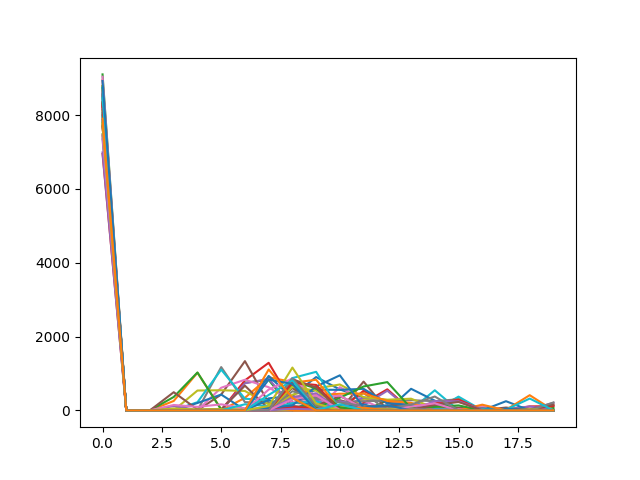

In [93]:
plt.figure()
for s in range(S):
    plt.plot(simplex_itr[:,s,0])

In [94]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [108]:
vu_fast_1_RL = (vb_fast_1_RL[1:]-vb_fast_1_RL[:xNsteps-1]+penalties[1:]-penalties[:xNsteps-1])/(X[1]-X[0])
vu_fast_2_RL = (vb_fast_2_RL[1:]-vb_fast_2_RL[:xNsteps-1]+penalties[1:]-penalties[:xNsteps-1])/(X[1]-X[0])
vu_accurate_1_RL = (vb_accurate_1_RL[1:]-vb_accurate_1_RL[:xNsteps-1]+penalties[1:]-penalties[:xNsteps-1])/(X[1]-X[0])
vu_accurate_2_RL = (vb_accurate_2_RL[1:]-vb_accurate_2_RL[:xNsteps-1]+penalties[1:]-penalties[:xNsteps-1])/(X[1]-X[0])
vu_accurate_1_MILP = (vb_accurate_1_MILP[1:]-vb_accurate_1_MILP[:xNsteps-1]+penalties[1:]-penalties[:xNsteps-1])/(X[1]-X[0])
vu_exact = (-vb_exact[1:]+vb_exact[:xNsteps-1]+penalties[1:]-penalties[:xNsteps-1])/(X[1]-X[0])

In [155]:
s = 50
# i = 0
# j = xNsteps
i = np.argmax([X>=reservoir.Xmin[s]])
j = np.argmin([X<=reservoir.Xmax[s]])

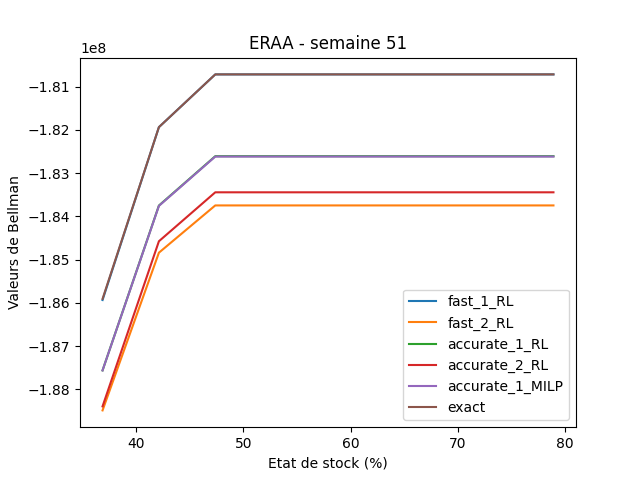

In [156]:
plt.figure()
plt.title(f"ERAA - semaine {s+1}")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Valeurs de Bellman")
plt.plot(X[i:j]/reservoir.capacity*100, vb_fast_1_RL[i:j, s]+penalties[i:j,s], label="fast_1_RL")
plt.plot(X[i:j]/reservoir.capacity*100, vb_fast_2_RL[i:j, s]+penalties[i:j,s], label="fast_2_RL")
plt.plot(X[i:j]/reservoir.capacity*100, vb_accurate_1_RL[i:j, s]+penalties[i:j,s], label="accurate_1_RL")
plt.plot(X[i:j]/reservoir.capacity*100, vb_accurate_2_RL[i:j, s]+penalties[i:j,s], label="accurate_2_RL")
plt.plot(X[i:j]/reservoir.capacity*100, vb_accurate_1_MILP[i:j, s]+penalties[i:j,s], label="accurate_1_MILP")
plt.plot(X[i:j]/reservoir.capacity*100, -vb_exact[i:j, s]+penalties[i:j,s], label="exact")
# plt.plot(U[i:j]/XmaxB*100, penalties[i:j, s], label="Pénalités")
plt.legend()
plt.show()

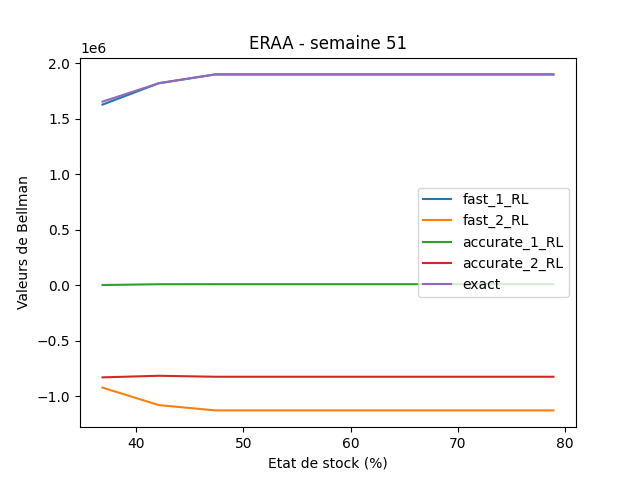

In [157]:
plt.figure()
plt.title(f"ERAA - semaine {s+1}")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Valeurs de Bellman")
plt.plot(X[i:j]/reservoir.capacity*100, (vb_fast_1_RL[i:j, s]-vb_accurate_1_MILP[i:j, s]), label="fast_1_RL")
plt.plot(X[i:j]/reservoir.capacity*100, (vb_fast_2_RL[i:j, s]-vb_accurate_1_MILP[i:j, s]), label="fast_2_RL")
plt.plot(X[i:j]/reservoir.capacity*100, (vb_accurate_1_RL[i:j, s]-vb_accurate_1_MILP[i:j, s]), label="accurate_1_RL")
plt.plot(X[i:j]/reservoir.capacity*100, (vb_accurate_2_RL[i:j, s]-vb_accurate_1_MILP[i:j, s]), label="accurate_2_RL")
plt.plot(X[i:j]/reservoir.capacity*100, (-vb_exact[i:j, s]-vb_accurate_1_MILP[i:j, s]), label="exact")
# plt.plot(X[i:j]/reservoir.capacity*100, vb_accurate_1_MILP[i:j, s]-vb_accurate_1_MILP[i:j, s], label="accurate_1_MILP")
# plt.plot(U[i:j]/XmaxB*100, penalties[i:j, s], label="Pénalités")
plt.legend()
plt.show()

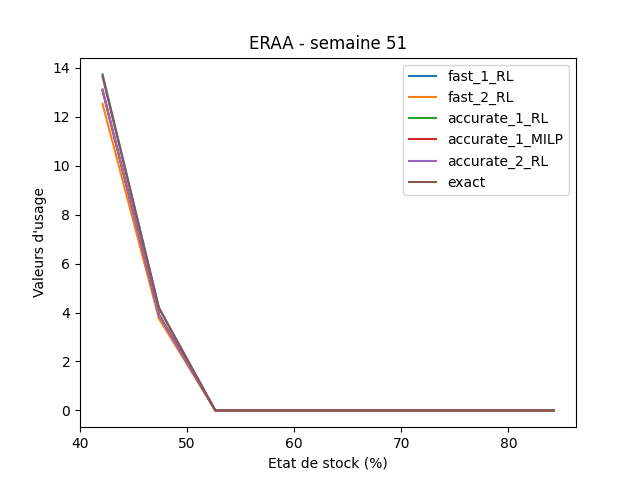

In [158]:
plt.figure()
plt.title(f"ERAA - semaine {s+1}")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Valeurs d'usage")
plt.plot(X[1:][i:j]/reservoir.capacity*100, vu_fast_1_RL[i:j, s], label="fast_1_RL")
plt.plot(X[1:][i:j]/reservoir.capacity*100, vu_fast_2_RL[i:j, s], label="fast_2_RL")
plt.plot(X[1:][i:j]/reservoir.capacity*100, vu_accurate_1_RL[i:j, s], label="accurate_1_RL")
plt.plot(X[1:][i:j]/reservoir.capacity*100, vu_accurate_1_MILP[i:j, s], label="accurate_1_MILP")
plt.plot(X[1:][i:j]/reservoir.capacity*100, vu_accurate_2_RL[i:j, s], label="accurate_2_RL")
plt.plot(X[1:][i:j]/reservoir.capacity*100, vu_exact[i:j, s], label="exact")
# plt.plot(U[i:j]/XmaxB*100, penalties[i:j, s], label="Pénalités")
plt.legend()
plt.show()

In [175]:
np.min(vu_exact)

-1.4089546410558885e-10

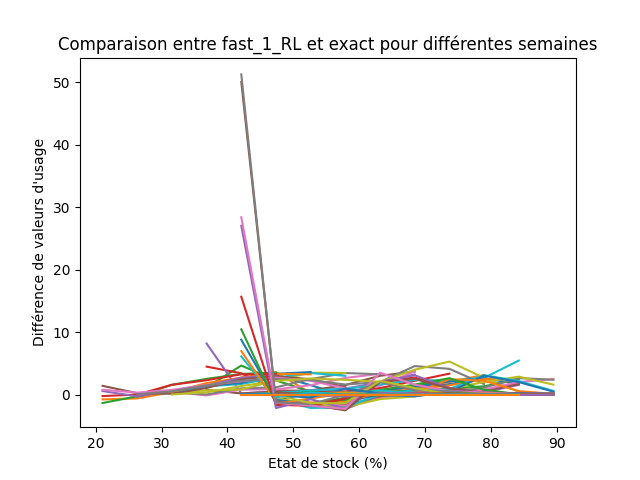

In [182]:
plt.figure()
plt.title("Comparaison entre fast_1_RL et exact pour différentes semaines")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Différence de valeurs d'usage")
for s in range(S):
    i = np.argmax([X>=reservoir.Xmin[s]])
    j = np.argmin([X<=reservoir.Xmax[s]])
    plt.plot(X[1:][i:j]/reservoir.capacity*100,(vu_fast_1_RL[i:j,s]-vu_exact[i:j, s]),label=f"{s}")#*100/(vu_exact[i:j, s]+1e6)
# plt.legend()

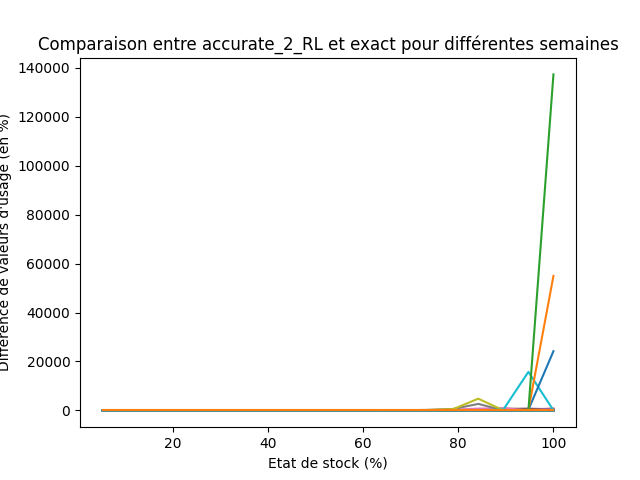

In [186]:
plt.figure()
plt.title("Comparaison entre accurate_2_RL et exact pour différentes semaines")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Différence de valeurs d'usage (en %)")
for s in range(S):
    i = 0#np.argmax([X>=reservoir.Xmin[s]])
    j = xNsteps#np.argmin([X<=reservoir.Xmax[s]])
    plt.plot(X[1:][i:j]/reservoir.capacity*100,(vu_fast_1_RL[i:j,s]-vu_exact[i:j, s])*100/(vu_exact[i:j, s]+1e-2),label=f"{s}")#
# plt.legend()

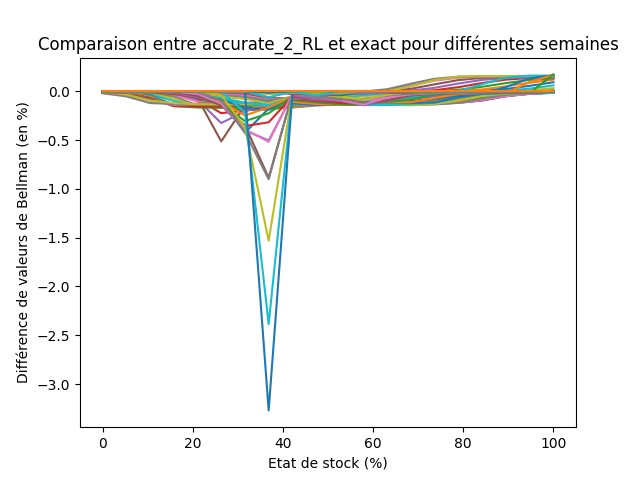

In [187]:
plt.figure()
plt.title("Comparaison entre accurate_2_RL et exact pour différentes semaines")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Différence de valeurs de Bellman (en %)")
for s in range(S):
    i = 0#np.argmax([X>=reservoir.Xmin[s]])
    j = xNsteps#np.argmin([X<=reservoir.Xmax[s]])
    plt.plot(X[i:j]/reservoir.capacity*100,(vb_fast_1_RL[i:j,s]+vb_exact[i:j, s])*100/(vb_exact[i:j, s]),label=f"{s}")#
# plt.legend()

### Variable inspection

In [11]:
s = 0

In [12]:
m = retrieve_problem(1,s+1,study_path+"/user/fast_fi00",itr=2)
m = modify_objective(m,U[s+1,0])
m.solve()

In [19]:
xp.rowinfo_dual

2

In [20]:
m.getrowinfo(xp.rowinfo_dual,0)

0.0

In [321]:
m.getObjVal()

132489630.96669197

In [322]:
vars = m.getVariable()

In [323]:
len(vars)

94080

In [324]:
df_vars = pd.DataFrame(vars, columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
coltype = []
m.getcoltype(coltype, 0, m.attributes.cols - 1)
df_vars['coltype'] = coltype
bounds = []
m.getlb(bounds, 0, m.attributes.cols - 1)
df_vars['lb'] = bounds
bounds = []
m.getub(bounds, 0, m.attributes.cols - 1)
df_vars['ub'] = bounds
objcoef = []
m.getobj(objcoef,0,m.attributes.cols-1)
df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
df_vars = df_vars.assign(sol=[m.getSolution(i) for i in range(m.attributes.cols)])
df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'])*np.round(df_vars['coeff']))

In [325]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,coltype,lb,ub,coeff,sol,obj
0,NTCDirect::link<2_nom1_hydro_open$$nom1>::hour...,"[NTCDirect, link<2_nom1_hydro_open$$nom1>, hou...",NTCDirect,link,2_nom1_hydro_open$$nom1,None,4368,C,-7.600000e+01,4.553000e+03,0.000000,2980.00000,0.0
1,NTCDirect::link<2_non1_hydro_open$$non1>::hour...,"[NTCDirect, link<2_non1_hydro_open$$non1>, hou...",NTCDirect,link,2_non1_hydro_open$$non1,None,4368,C,-2.000000e+00,6.441000e+03,0.000000,1577.00000,0.0
2,NTCDirect::link<2_nos0_hydro_open$$nos0>::hour...,"[NTCDirect, link<2_nos0_hydro_open$$nos0>, hou...",NTCDirect,link,2_nos0_hydro_open$$nos0,None,4368,C,-1.016000e+03,2.348600e+04,0.000000,8945.00000,0.0
3,NTCDirect::link<5_batt_pump$$5_batt_pump_row>:...,"[NTCDirect, link<5_batt_pump$$5_batt_pump_row>...",NTCDirect,link,5_batt_pump$$5_batt_pump_row,None,4368,C,-1.000000e+20,1.000000e+20,0.000000,-0.00000,-0.0
4,NTCDirect::link<5_batt_pump$$fi00>::hour<4368>...,"[NTCDirect, link<5_batt_pump$$fi00>, hour<4368>]",NTCDirect,link,5_batt_pump$$fi00,None,4368,C,-7.620000e+01,0.000000e+00,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94075,HydProd::area<fi00>::hour<4535> ...,"[HydProd, area<fi00>, hour<4535>]",HydProd,area,fi00,None,4535,C,0.000000e+00,0.000000e+00,0.000936,0.00000,0.0
94076,HydProd::area<se01>::hour<4535> ...,"[HydProd, area<se01>, hour<4535>]",HydProd,area,se01,None,4535,C,0.000000e+00,4.582000e+03,-0.000776,358.00000,-0.0
94077,HydProd::area<se02>::hour<4535> ...,"[HydProd, area<se02>, hour<4535>]",HydProd,area,se02,None,4535,C,0.000000e+00,5.996000e+03,0.000713,999.79904,0.0
94078,HydProd::area<se03>::hour<4535> ...,"[HydProd, area<se03>, hour<4535>]",HydProd,area,se03,None,4535,C,0.000000e+00,1.424000e+03,0.000704,1424.00000,0.0


In [326]:
np.unique(df_vars["name_antares_object"])

array(['2_nom1_hydro_open', '2_nom1_hydro_open$$nom1',
       '2_non1_hydro_open', '2_non1_hydro_open$$non1',
       '2_nos0_hydro_open', '2_nos0_hydro_open$$nos0', '5_batt_pump',
       '5_batt_pump$$5_batt_pump_row', '5_batt_pump$$fi00',
       '5_batt_pump_row', '5_batt_rsvr', '91_idev_pump',
       '91_idev_pump$$91_idev_pump_row', '91_idev_pump$$fi00',
       '91_idev_pump$$se01', '91_idev_pump$$se02', '91_idev_pump$$se03',
       '91_idev_pump$$se04', '91_idev_pump_row', '92_idh_pump',
       '92_idh_pump$$92_idh_pump_row', '92_idh_pump$$dke1',
       '92_idh_pump$$dkw1', '92_idh_pump$$fi00', '92_idh_pump_row',
       'dke1', 'dke1$$dke1_row', 'dke1$$dkw1', 'dke1$$se04', 'dke1_row',
       'dkw1', 'dkw1$$dkw1_row', 'dkw1$$nos0', 'dkw1$$se03', 'dkw1_row',
       'fi00', 'fi00$$fi00_row', 'fi00$$fictive_watervalues_pump',
       'fi00$$fictive_watervalues_turb', 'fi00$$se01', 'fi00$$se03',
       'fi00_row', 'fictive_watervalues_pump', 'fictive_watervalues_turb',
       'nom1', 'no

In [327]:
cout_par_pays = df_vars.groupby("name_antares_object")["obj"].sum()

In [328]:
cout_par_pays[cout_par_pays>0]

name_antares_object
dke1    14381255.0
dkw1    16644718.0
fi00    52265460.0
nom1      593600.0
non1      379400.0
nos0      466200.0
se01     3581856.0
se02     5388338.0
se03    31766302.0
se04     7007810.0
Name: obj, dtype: float64

In [329]:
idx_fictive = df_vars[df_vars['name_antares_object'].isin([a for a in np.unique(df_vars['name_antares_object']) if "fictive" in a])].index

In [330]:
sum([df_vars["obj"][i] for i in idx_fictive])

0.0

In [331]:
idx_hour0 = df_vars[(df_vars['time']==4368)].index #&(df_vars['name_antares_object']=="dke1")

In [332]:
sum([df_vars["obj"][i] for i in idx_hour0])

755352.0

In [333]:
df_vars_hour0 = df_vars[(df_vars['time']==4368)] #&(df_vars['name_antares_object']=="dke1")

In [334]:
df_vars_hour0

,names,split,name_var,antares_object,name_antares_object,subobject,time,coltype,lb,ub,coeff,sol,obj
0,NTCDirect::link<2_nom1_hydro_open$$nom1>::hour...,"[NTCDirect, link<2_nom1_hydro_open$$nom1>, hou...",NTCDirect,link,2_nom1_hydro_open$$nom1,None,4368,C,-7.600000e+01,4.553000e+03,0.000000,2980.00000,0.0
1,NTCDirect::link<2_non1_hydro_open$$non1>::hour...,"[NTCDirect, link<2_non1_hydro_open$$non1>, hou...",NTCDirect,link,2_non1_hydro_open$$non1,None,4368,C,-2.000000e+00,6.441000e+03,0.000000,1577.00000,0.0
2,NTCDirect::link<2_nos0_hydro_open$$nos0>::hour...,"[NTCDirect, link<2_nos0_hydro_open$$nos0>, hou...",NTCDirect,link,2_nos0_hydro_open$$nos0,None,4368,C,-1.016000e+03,2.348600e+04,0.000000,8945.00000,0.0
3,NTCDirect::link<5_batt_pump$$5_batt_pump_row>:...,"[NTCDirect, link<5_batt_pump$$5_batt_pump_row>...",NTCDirect,link,5_batt_pump$$5_batt_pump_row,None,4368,C,-1.000000e+20,1.000000e+20,0.000000,-0.00000,-0.0
4,NTCDirect::link<5_batt_pump$$fi00>::hour<4368>...,"[NTCDirect, link<5_batt_pump$$fi00>, hour<4368>]",NTCDirect,link,5_batt_pump$$fi00,None,4368,C,-7.620000e+01,0.000000e+00,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,HydProd::area<fi00>::hour<4368> ...,"[HydProd, area<fi00>, hour<4368>]",HydProd,area,fi00,None,4368,C,0.000000e+00,0.000000e+00,-0.000728,0.00000,-0.0
556,HydProd::area<se01>::hour<4368> ...,"[HydProd, area<se01>, hour<4368>]",HydProd,area,se01,None,4368,C,0.000000e+00,4.582000e+03,-0.000692,2079.66496,-0.0
557,HydProd::area<se02>::hour<4368> ...,"[HydProd, area<se02>, hour<4368>]",HydProd,area,se02,None,4368,C,0.000000e+00,5.996000e+03,0.000669,4566.13102,0.0
558,HydProd::area<se03>::hour<4368> ...,"[HydProd, area<se03>, hour<4368>]",HydProd,area,se03,None,4368,C,0.000000e+00,1.424000e+03,-0.000965,1424.00000,-0.0


In [335]:
len(df_vars_hour0)

560

In [336]:
np.round(df_vars_hour0["obj"]).sum()

755352.0

In [337]:
df_vars[(df_vars["name_var"]=='DispatchableProduction')].groupby("name_antares_object")["sol"].sum()

name_antares_object
5_batt_rsvr                 9.779133e+06
dke1                        1.251827e+05
dkw1                        1.538804e+05
fi00                        8.276789e+05
fictive_watervalues_turb    0.000000e+00
nom1                        6.328000e+03
non1                        3.465700e+04
nos0                        1.073100e+04
se01                        1.827147e+04
se02                        2.746053e+04
se03                        1.154474e+06
se04                        3.283972e+04
w_hvac_fo                   8.741961e+06
w_hvdc_fo                   6.483213e+06
w_hydro                     9.666000e+05
w_spillage                  2.520000e+07
y_idbt_rsvr                 4.913580e+05
y_idev_rsvr                 2.985451e+05
y_idhp_rsvr                 5.521785e+06
Name: sol, dtype: float64

In [338]:
df_vars[(df_vars["name_var"]=='HydProd')].groupby("name_antares_object")["sol"].sum()

name_antares_object
2_nom1_hydro_open    3.479599e+05
2_non1_hydro_open    2.841723e+05
2_nos0_hydro_open    1.437122e+06
fi00                 0.000000e+00
se01                 1.338439e+05
se02                 5.090311e+05
se03                 1.252661e+05
se04                 1.555400e+04
Name: sol, dtype: float64

In [305]:
np.round(df_vars[(df_vars["name_var"]=='PositiveUnsuppliedEnergy')&((df_vars['time']==4368))]["sol"]).sum()

500000.0

In [306]:
np.round(df_vars[(df_vars["name_var"]=='NegativeUnsuppliedEnergy')&((df_vars['time']==4368))]["sol"]).sum()

326327.0

In [307]:
np.round(df_vars[(df_vars["name_var"]=='HydProd')&((df_vars['time']==4368))]["sol"]).sum()

21803.0

In [286]:
329956+2004+3008+24135

359103

In [242]:
np.unique(df_vars["name_var"])

array(['DispatchableProduction', 'HydProd', 'HydroLevel',
       'IntercoDirectCost', 'IntercoIndirectCost', 'NTCDirect',
       'NegativeUnsuppliedEnergy', 'Overflow', 'PositiveUnsuppliedEnergy',
       'Pumping'], dtype=object)

In [243]:
cons = m.getConstraint()

In [244]:
len(cons)

21291

In [313]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [314]:
df_cons

,names,split,name_cons,antares_object,name_antares_object,time,rhs
0,AreaBalance::area<2_nom1_hydro_open>::hour<436...,"[AreaBalance, area<2_nom1_hydro_open>, hour<43...",AreaBalance,area,2_nom1_hydro_open,4368,0.000000
1,FictiveLoads::area<2_nom1_hydro_open>::hour<43...,"[FictiveLoads, area<2_nom1_hydro_open>, hour<4...",FictiveLoads,area,2_nom1_hydro_open,4368,0.000000
2,AreaBalance::area<2_non1_hydro_open>::hour<436...,"[AreaBalance, area<2_non1_hydro_open>, hour<43...",AreaBalance,area,2_non1_hydro_open,4368,0.000000
3,FictiveLoads::area<2_non1_hydro_open>::hour<43...,"[FictiveLoads, area<2_non1_hydro_open>, hour<4...",FictiveLoads,area,2_non1_hydro_open,4368,0.000000
4,AreaBalance::area<2_nos0_hydro_open>::hour<436...,"[AreaBalance, area<2_nos0_hydro_open>, hour<43...",AreaBalance,area,2_nos0_hydro_open,4368,0.000000
...,...,...,...,...,...,...,...
21286,AreaHydroLevel::area<2_non1_hydro_open>::hour<...,"[AreaHydroLevel, area<2_non1_hydro_open>, hour...",AreaHydroLevel,area,2_non1_hydro_open,4534,12987.875000
21287,AreaHydroLevel::area<2_nos0_hydro_open>::hour<...,"[AreaHydroLevel, area<2_nos0_hydro_open>, hour...",AreaHydroLevel,area,2_nos0_hydro_open,4534,16987.750000
21288,AreaHydroLevel::area<2_nom1_hydro_open>::hour<...,"[AreaHydroLevel, area<2_nom1_hydro_open>, hour...",AreaHydroLevel,area,2_nom1_hydro_open,4535,5956.041667
21289,AreaHydroLevel::area<2_non1_hydro_open>::hour<...,"[AreaHydroLevel, area<2_non1_hydro_open>, hour...",AreaHydroLevel,area,2_non1_hydro_open,4535,12987.875000


In [315]:
np.unique(df_cons["name_cons"])

array(['AreaBalance', 'AreaHydroLevel', 'BC1_batt_fi00', 'BC1_idev_fi00',
       'BC1_idev_se01', 'BC1_idev_se02', 'BC1_idev_se03', 'BC1_idev_se04',
       'BC1_idhp_dke1', 'BC1_idhp_dkw1', 'BC1_idhp_fi00', 'BC2_batt_fi00',
       'BC2_idev_fi00', 'BC2_idev_se01', 'BC2_idev_se02', 'BC2_idev_se03',
       'BC2_idev_se04', 'BC2_idhp_dke1', 'BC2_idhp_dkw1', 'BC2_idhp_fi00',
       'BC_fi00_dsr_pb_100', 'BC_fi00_dsr_pb_240', 'BC_fi00_dsr_pb_50',
       'BC_nom1_dsr_pb_200', 'BC_nom1_dsr_pb_500', 'BC_non1_dsr_pb_200',
       'BC_non1_dsr_pb_375', 'BC_non1_dsr_pb_500', 'BC_nos0_dsr_pb_200',
       'BC_nos0_dsr_pb_500', 'EVA_DSR_FI00_9', 'EVA_DSR_SE03_250',
       'EVA_DSR_SE03_500', 'EVA_DSR_SE04_250', 'EVA_DSR_SE04_500',
       'FictiveLoads', 'FlowDissociation', 'HVC_FO_D_DKE1_DKW1',
       'HVC_FO_D_DKE1_SE04', 'HVC_FO_D_DKW1_NOS0', 'HVC_FO_D_DKW1_SE03',
       'HVC_FO_D_FI00_SE01', 'HVC_FO_D_FI00_SE03', 'HVC_FO_D_SE01_SE02',
       'HVC_FO_D_SE02_SE03', 'HVC_FO_D_SE03_SE04', 'HVC_FO_I_DK

In [317]:
df_cons[(df_cons['time']==4368)].groupby("name_cons")["rhs"].sum()

name_cons
AreaBalance          -5.358048e+05
AreaHydroLevel        5.657454e+07
BC1_batt_fi00         0.000000e+00
BC1_idev_fi00         0.000000e+00
BC1_idev_se01         0.000000e+00
BC1_idev_se02         0.000000e+00
BC1_idev_se03         0.000000e+00
BC1_idev_se04         0.000000e+00
BC1_idhp_dke1         0.000000e+00
BC1_idhp_dkw1         0.000000e+00
BC1_idhp_fi00         0.000000e+00
BC2_batt_fi00         0.000000e+00
BC2_idev_fi00         0.000000e+00
BC2_idev_se01         0.000000e+00
BC2_idev_se02         0.000000e+00
BC2_idev_se03         0.000000e+00
BC2_idev_se04         0.000000e+00
BC2_idhp_dke1         0.000000e+00
BC2_idhp_dkw1         0.000000e+00
BC2_idhp_fi00         0.000000e+00
FictiveLoads          9.503200e+03
FlowDissociation      0.000000e+00
HVC_FO_D_DKE1_DKW1    0.000000e+00
HVC_FO_D_DKE1_SE04    0.000000e+00
HVC_FO_D_DKW1_NOS0    0.000000e+00
HVC_FO_D_DKW1_SE03    0.000000e+00
HVC_FO_D_FI00_SE01    0.000000e+00
HVC_FO_D_FI00_SE03    0.000000e+00
HVC_FO_D_S

In [319]:
df_cons[(df_cons['name_cons']=='HydroPower')].groupby("name_antares_object")["rhs"].sum()

name_antares_object
2_nom1_hydro_open    3.479599e+05
2_non1_hydro_open    2.841723e+05
2_nos0_hydro_open    1.437122e+06
fi00                 0.000000e+00
se01                 1.338439e+05
se02                 5.090311e+05
se03                 1.252661e+05
se04                 1.555400e+04
Name: rhs, dtype: float64

In [291]:
1.530871e+04+2.715200e+02

15580.23

In [250]:
1017.1+467.9

1485.0

In [251]:
435+63+519

1017

In [253]:
2079-1484

595

## Turbinage

In [7]:
turb_8_1 = np.array([271732,
21591,
355713,
256059,
398987,
277919,
179353,
308921,
93999,
57416,
96030,
128143,
29455,
289778,
390749,
398231,
403201,
282092,
381879,
572819,
621757,
508544,
962654,
639380,
631924,
737639,
1001533,
639426,
507370,
343637,
946804,
654850,
305262,
862012,
728332,
319033,
291079,
261024,
453490,
632050,
725594,
498695,
525956,
410949,
317477,
310624,
200755,
453286,
243070,
307269,
107715,
226550
])

In [33]:
turb_8_2 = np.array([271732,
21591,
355713,
256059,
398987,
277919,
179353,
308921,
93999,
57416,
96030,
128143,
29466,
368192,
474846,
503328,
497182,
334246,
381879,
572819,
621757,
508544,
972720,
971376,
1006824,
998928,
509031,
631712,
371763,
974749,
1020473,
665100,
313963,
915784,
702737,
216360,
197402,
177020,
307545,
294176,
606378,
358490,
233597,
218814,
317477,
310624,
200755,
453286,
243070,
307269,
107715,
226550
])

In [8]:
turb_8_7 = np.array([
    271732,
21591,
355713,
256059,
398987,
277919,
179353,
308921,
93999,
57416,
96030,
128143,
29466,
368192,
474846,
503328,
497182,
334246,
381879,
572819,
621757,
508544,
972720,
971376,
1006824,
998928,
509031,
631712,
371763,
974749,
1020473,
665100,
313963,
915784,
702737,
216360,
197402,
177020,
307545,
294176,
606378,
358490,
233597,
218814,
317477,
310624,
200755,
453286,
243070,
307269,
107715,
226550

])

In [10]:
apport = np.array([-80059,
-140532,
-174454,
-149674,
-169540,
-154966,
-206164,
-200452,
-108955,
-97958,
-69307,
-13881,
381794,
414890,
216937,
409717,
1106231,
953498,
1431451,
1542177,
2437428,
3489570,
1974350,
639380,
477169,
701988,
1191939,
604625,
542171,
282982,
101402,
107317,
228312,
304213,
325388,
273819,
616105,
739333,
489853,
248787,
108199,
10283,
159915,
344512,
146776,
239169,
93429,
28238,
-55573,
-24416,
-55762,
31899])


In [13]:
load = np.array([478496,
435158,
425297,
434727,
431741,
426303,
394268,
414818,
405546,
407496,
394658,
387456,
365494,
363366,
375703,
357516,
351091,
355574,
348576,
351435,
339906,
328168,
337746,
343051,
336956,
326476,
325312,
317237,
319710,
320818,
314646,
318633,
323624,
325685,
324566,
336890,
330021,
328642,
338010,
343561,
367891,
381073,
370872,
370704,
390333,
382503,
385772,
390125,
398768,
406715,
396388,
378922])


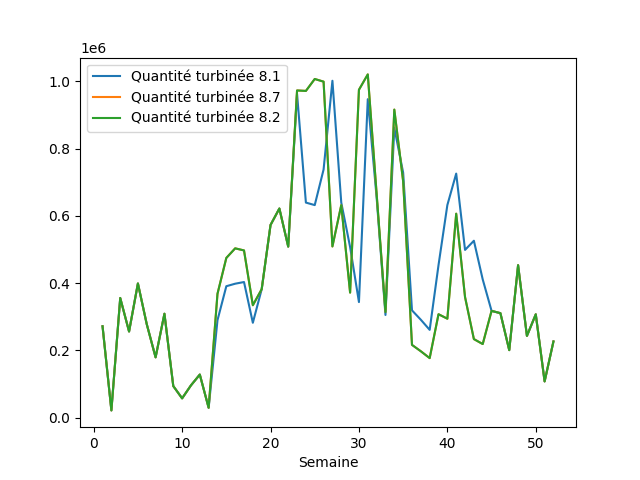

In [36]:
plt.figure()
plt.plot(np.arange(1,53),turb_8_1,label="Quantité turbinée 8.1")
plt.plot(np.arange(1,53),turb_8_7,label="Quantité turbinée 8.7")
plt.plot(np.arange(1,53),turb_8_2,label="Quantité turbinée 8.2")
# plt.plot(np.arange(1,53),apport,label="Apports")
# plt.plot(np.arange(1,53),load,label="Demande")
plt.xlabel("Semaine")
plt.legend()

In [37]:
turb_8_2-turb_8_7

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])